In [5]:
import os, sys, warnings, pytz, json
import pandas as pd
import numpy as np


warnings.filterwarnings("ignore")  # keep logs tidy

# ------------------- helper-package path --------------------
sys.path.append(r"C:\WFM_Scripting\Automation")  # adjust if needed
from scripthelper import Config, Logger, BigQueryManager, EmailManager
# ==============================================================================
# SECTION 1: DATA SOURCES (QUERIES AND FILE PATHS)
# ==============================================================================
# Define all queries and file paths
sql_tickets_historicals = r"C:\WFM_Scripting\Forecasting\GBQ - Non-Tax Platform Ticket Timeseries by Month.sql"
sql_workload_driver = "SELECT MonthOfOrder, client_id, TotalOrders FROM tax_clnt_svcs.view_cx_nontax_platforms_workload_drivers"
sql_fred = "SELECT Date, UNRATE, HSN1F, FEDFUNDS, MORTGAGE30US FROM tax_clnt_svcs.fred WHERE Date >= '2023-01-01'"
file_market_guidance = r"C:\Users\jhgonzalez\OneDrive - CoreLogic Solutions, LLC\Desktop\Market_G.xlsx"

# ==============================================================================
# SECTION 2: DATA LOADING
# ==============================================================================
# Initialize the connection manager and load all data sources
print("Loading data from sources...")
bq_manager = BigQueryManager(Config(rpt_id=9999)) # Use your report ID

tickets_historicals = bq_manager.run_gbq_sql(sql_tickets_historicals, return_dataframe=True)
workload_driver = bq_manager.run_gbq_sql(sql_workload_driver, return_dataframe=True)
FRED = bq_manager.run_gbq_sql(sql_fred, return_dataframe=True)
market_guidance = pd.read_excel(file_market_guidance)

print("All data sources loaded successfully.")

# ==============================================================================
# SECTION 3: MERGING ALL DATA SOURCES
# ==============================================================================
print("\nMerging all data sources...")

# Prepare workload_driver with special client mappings
workload_driver_prep = workload_driver.copy()
client_mapping = {
    'FNC - CMS': 'FNC',
    'FNC - Ports': 'FNC',
    'Mercury Integrations': 'Mercury'
}
workload_driver_prep['client_id'] = workload_driver_prep['client_id'].replace(client_mapping)
workload_driver_agg = workload_driver_prep.groupby(['MonthOfOrder', 'client_id'])['TotalOrders'].sum().reset_index()
workload_driver_agg = workload_driver_agg.rename(columns={'MonthOfOrder': 'date'})
workload_driver_agg['date'] = pd.to_datetime(workload_driver_agg['date'])

# Prepare tickets_historicals with a temporary join key for mapping
tickets_historicals['date'] = pd.to_datetime(tickets_historicals['date'])
tickets_historicals_prep = tickets_historicals.copy()
tickets_historicals_prep['join_key'] = tickets_historicals_prep['client_id']
fnc_variants = ['FNC - CMS', 'FNC - Ports']
tickets_historicals_prep.loc[tickets_historicals_prep['client_id'].isin(fnc_variants), 'join_key'] = 'FNC'
mercury_start_date = pd.to_datetime('2023-05-01')
mercury_mask = (tickets_historicals_prep['client_id'] == 'Mercury Integrations') & (tickets_historicals_prep['date'] >= mercury_start_date)
tickets_historicals_prep.loc[mercury_mask, 'join_key'] = 'Mercury'

# Merge tickets with workload
merged_df = pd.merge(
    tickets_historicals_prep,
    workload_driver_agg,
    left_on=['date', 'join_key'],
    right_on=['date', 'client_id'],
    how='left'
)
merged_df = merged_df.drop(columns=['join_key', 'client_id_y']).rename(columns={'client_id_x': 'client_id'})

# Merge with FRED data
FRED['Date'] = pd.to_datetime(FRED['Date'])
FRED_prep = FRED.rename(columns={'Date': 'date'})
final_df = pd.merge(merged_df, FRED_prep, on='date', how='left')

# Merge with Market Guidance data
market_guidance['DATE'] = pd.to_datetime(market_guidance['DATE'])
market_guidance_prep = market_guidance.rename(columns={'DATE': 'date'})
final_df = pd.merge(final_df, market_guidance_prep, on='date', how='left')
print("All merges complete.")


df = final_df
# ==============================================================================
# SECTION 4: DATA CLEANING (IMPUTATION)
# ==============================================================================
print("\nCleaning final DataFrame by filling missing values...")
columns_to_fill = [
    'UNRATE', 'HSN1F', 'FEDFUNDS', 'MORTGAGE30US',
    'Purchase', 'Refinance', 'Year-over-year Variance'
]
# Forward fill to propagate last known values
for col in columns_to_fill:
    final_df[col] = final_df[col].ffill()
# Backward fill to handle any NaNs at the very start
for col in columns_to_fill:
    final_df[col] = final_df[col].bfill()
print("Missing values filled.")

# ==============================================================================
# SECTION 5: SAVE FINAL, CLEANED DATA
# ==============================================================================
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
output_file_path = os.path.join(desktop_path, 'merged_forecasting_data.csv')

try:
    final_df.to_csv(output_file_path, index=False)
    print(f"\n✅ DataFrame with all data successfully saved to:\n{output_file_path}")
except Exception as e:
    print(f"\n🔥 An error occurred while saving the file: {e}")

Loading data from sources...
All data sources loaded successfully.

Merging all data sources...
All merges complete.

Cleaning final DataFrame by filling missing values...
Missing values filled.

✅ DataFrame with all data successfully saved to:
C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv


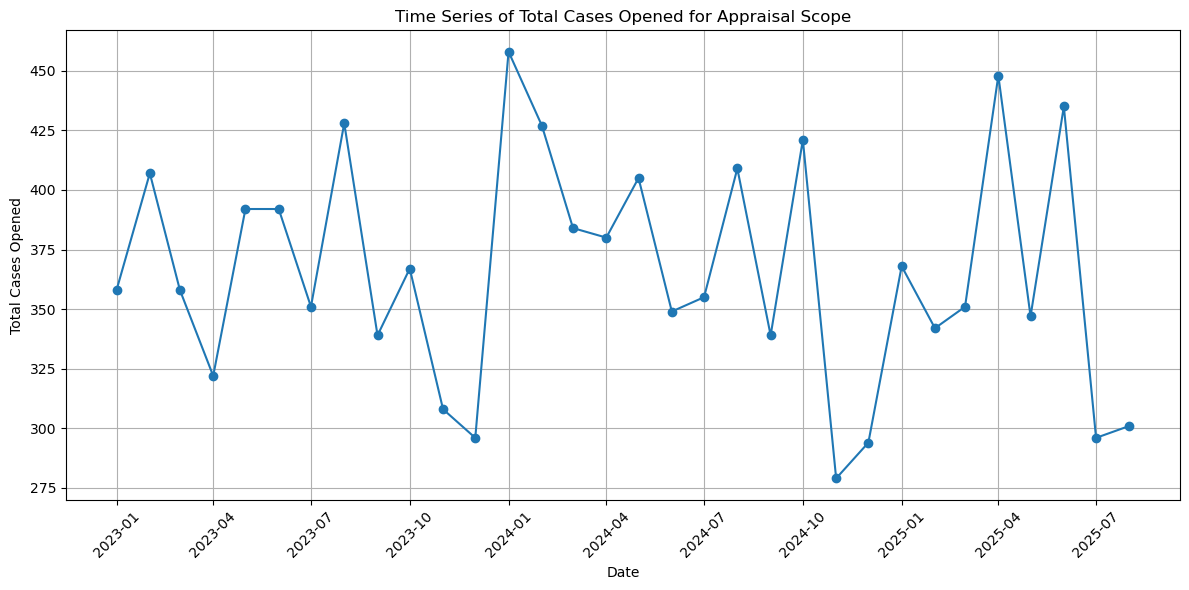

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Prepare the Data ---
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the 'Appraisal Scope' client
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()


# --- 2. Create the Plot ---
plt.figure(figsize=(12, 6))
plt.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], marker='o', linestyle='-')

# Formatting the x-axis for readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# --- 3. Final Touches ---
plt.title('Time Series of Total Cases Opened for Appraisal Scope')
plt.xlabel('Date')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.tight_layout()
plt.show()

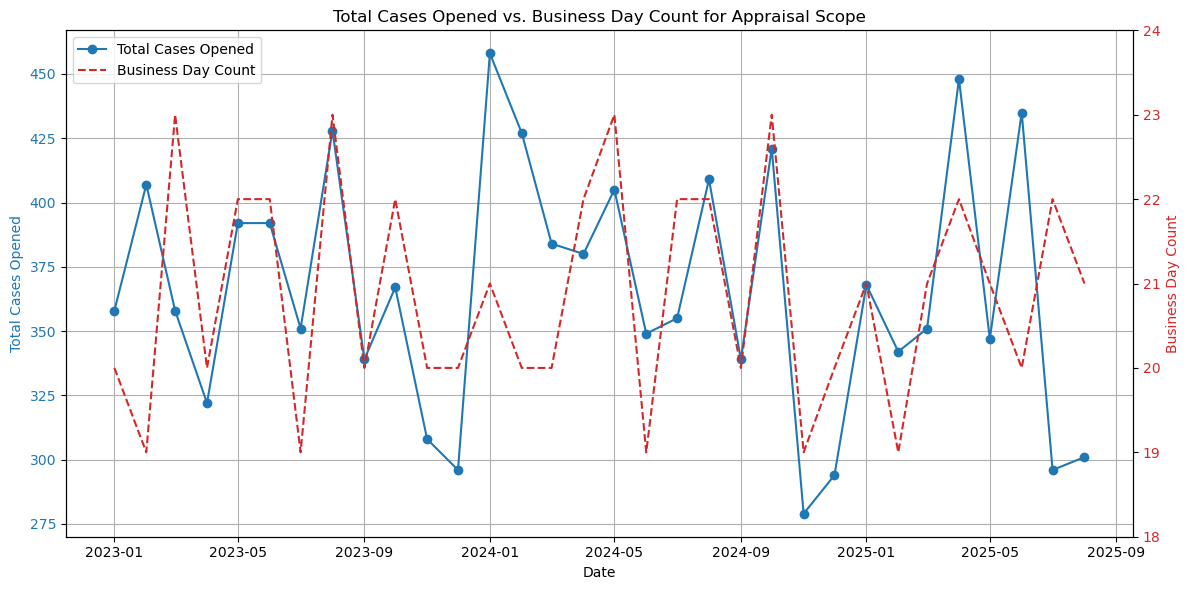

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare the Data ---
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the 'Appraisal Scope' client
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()


# --- 2. Create the Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the primary variable (Total Cases Opened)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True) # Add grid lines for the primary axis

# Creating the second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Business Day Count', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['business_day_count'], color=color, linestyle='--', label='Business Day Count')
ax2.tick_params(axis='y', labelcolor=color)

# Manually set the y-axis limits to ensure variation is visible
min_val = appraisal_scope_df['business_day_count'].min()
max_val = appraisal_scope_df['business_day_count'].max()
ax2.set_ylim(min_val - 1, max_val + 1)

# --- 3. Final Touches ---
plt.title('Total Cases Opened vs. Business Day Count for Appraisal Scope')
fig.tight_layout()
# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

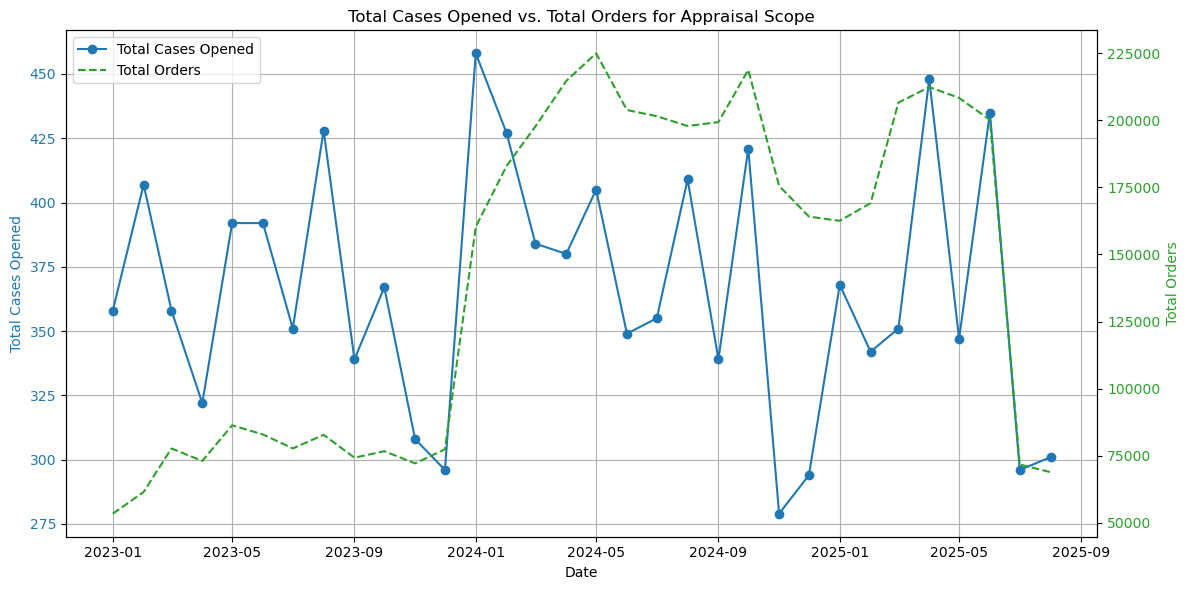

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare the Data ---
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for the 'Appraisal Scope' client
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()


# --- 2. Create the Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the primary variable (Total Cases Opened)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Creating the second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Total Orders', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['TotalOrders'], color=color, linestyle='--', label='Total Orders')
ax2.tick_params(axis='y', labelcolor=color)


# --- 3. Final Touches ---
plt.title('Total Cases Opened vs. Total Orders for Appraisal Scope')
fig.tight_layout()
# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

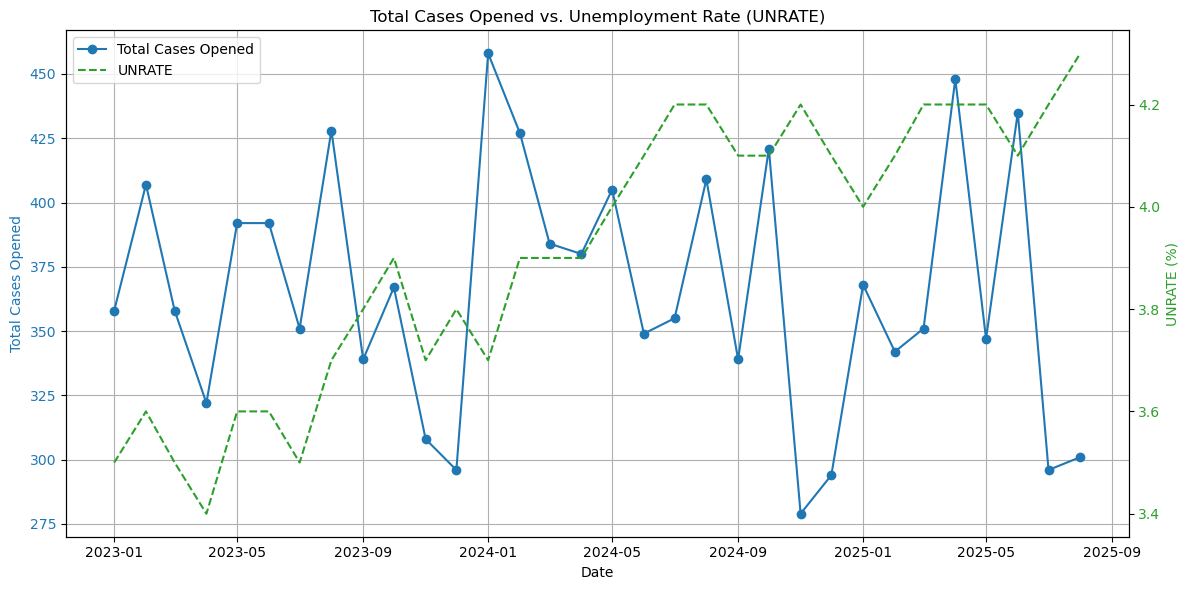

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('UNRATE (%)', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['UNRATE'], color=color, linestyle='--', label='UNRATE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. Unemployment Rate (UNRATE)')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

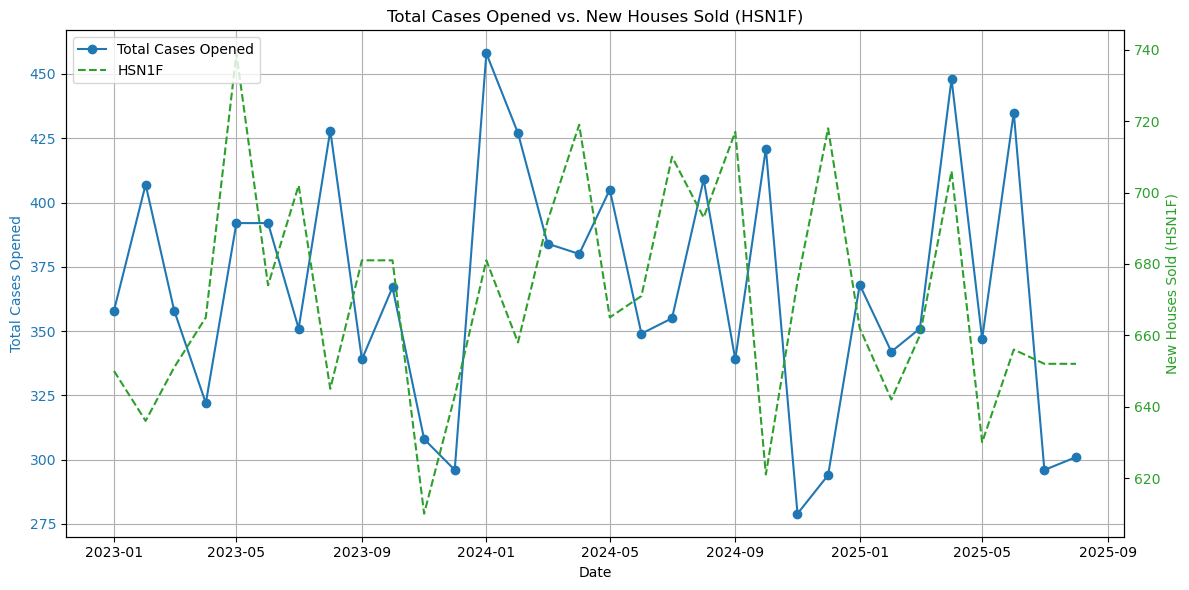

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('New Houses Sold (HSN1F)', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['HSN1F'], color=color, linestyle='--', label='HSN1F')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. New Houses Sold (HSN1F)')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

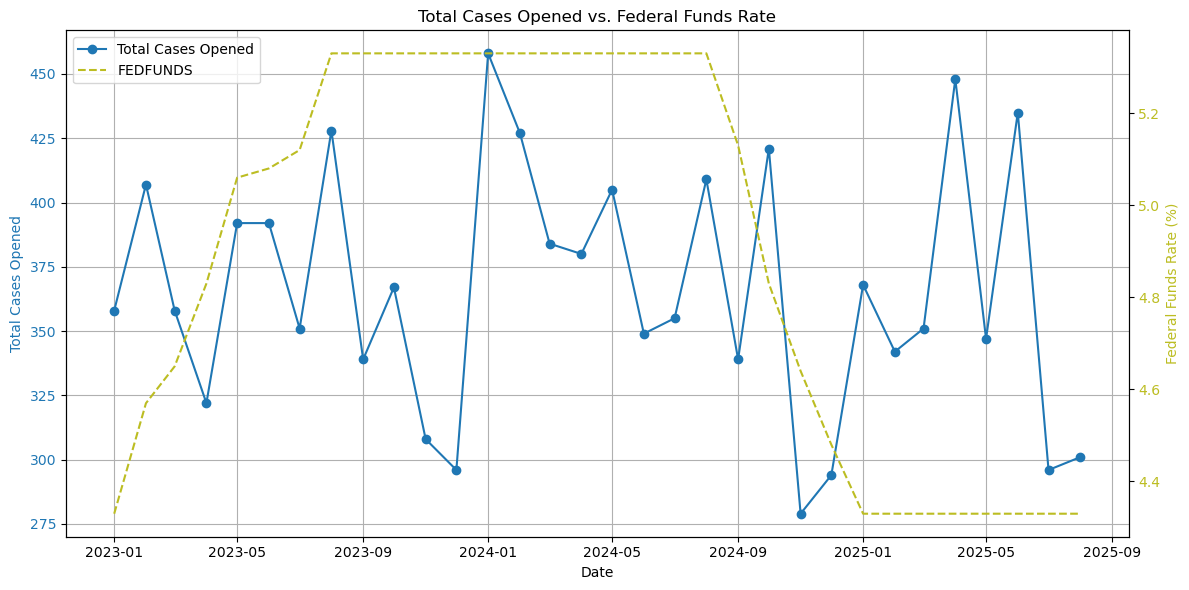

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:olive'
ax2.set_ylabel('Federal Funds Rate (%)', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['FEDFUNDS'], color=color, linestyle='--', label='FEDFUNDS')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. Federal Funds Rate')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

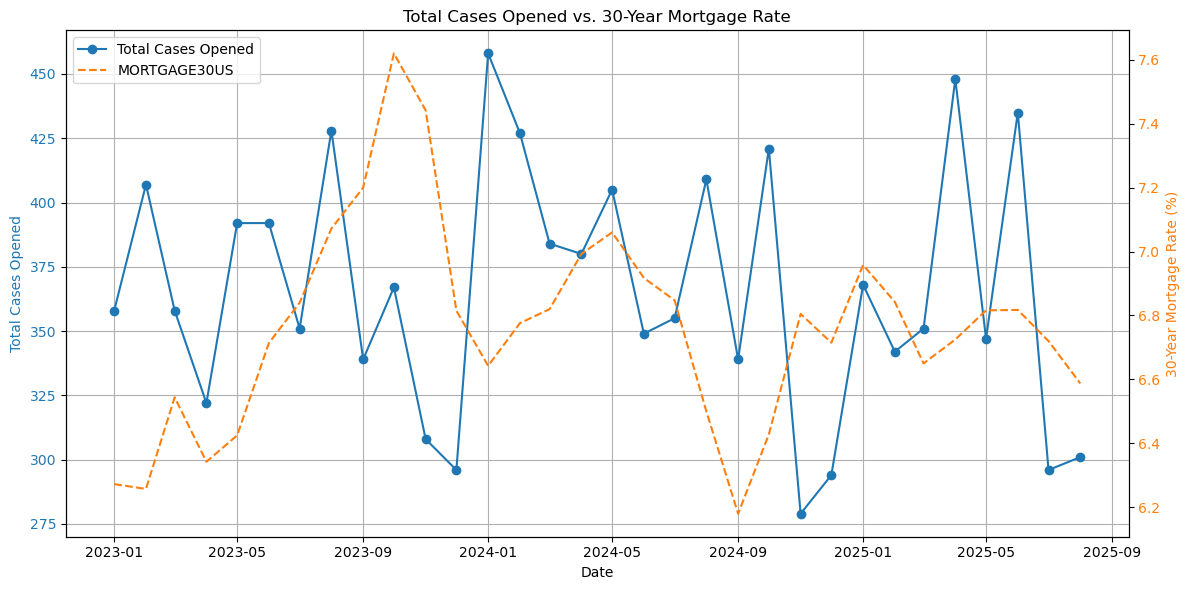

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('30-Year Mortgage Rate (%)', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['MORTGAGE30US'], color=color, linestyle='--', label='MORTGAGE30US')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. 30-Year Mortgage Rate')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

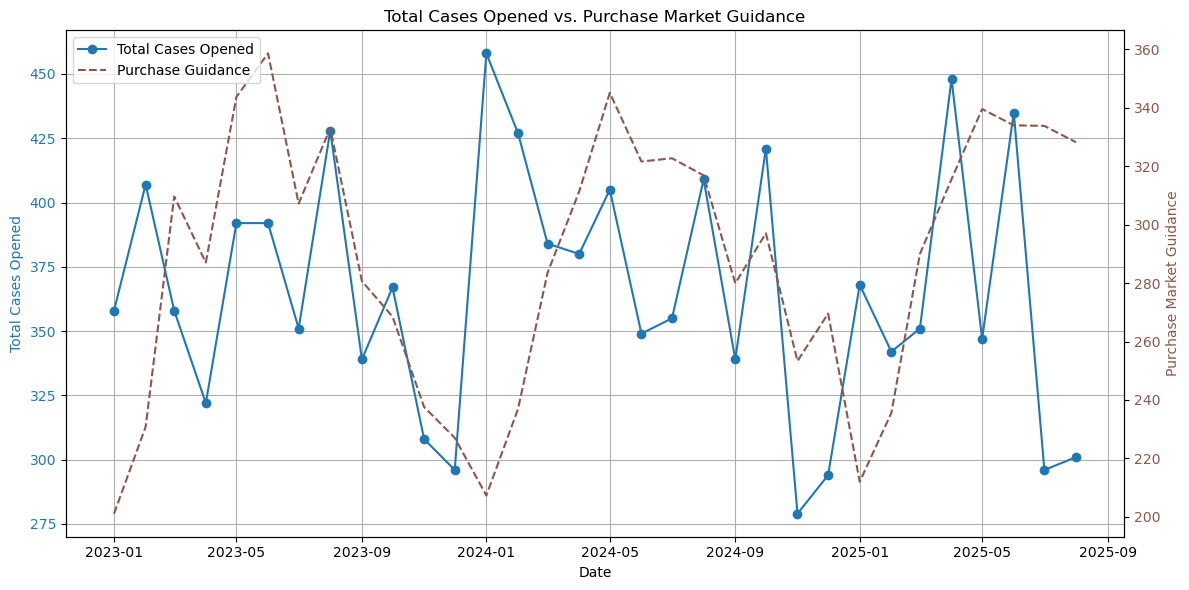

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:brown'
ax2.set_ylabel('Purchase Market Guidance', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['Purchase'], color=color, linestyle='--', label='Purchase Guidance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. Purchase Market Guidance')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

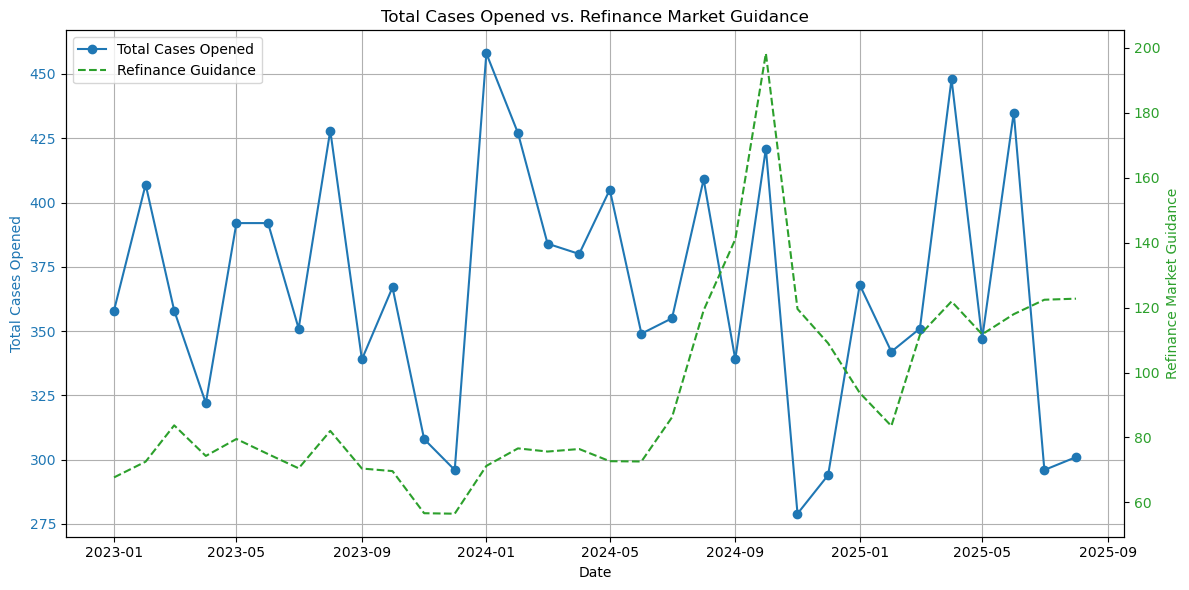

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Refinance Market Guidance', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['Refinance'], color=color, linestyle='--', label='Refinance Guidance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. Refinance Market Guidance')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

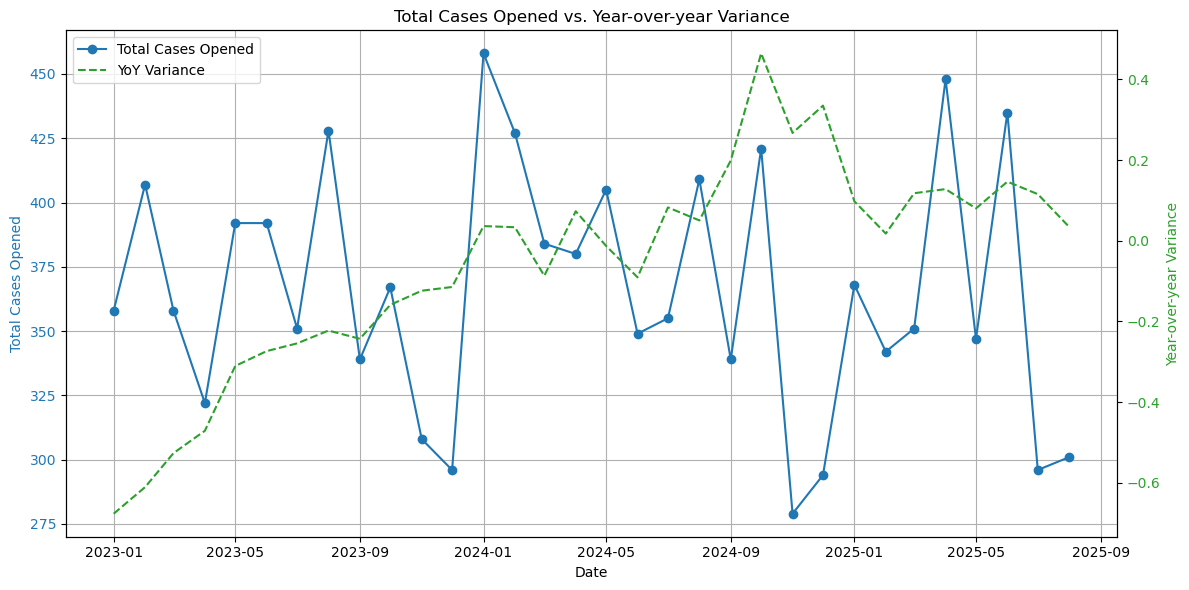

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases Opened', color=color)
ax1.plot(appraisal_scope_df['date'], appraisal_scope_df['total_cases_opened'], color=color, marker='o', label='Total Cases Opened')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Year-over-year Variance', color=color)
ax2.plot(appraisal_scope_df['date'], appraisal_scope_df['Year-over-year Variance'], color=color, linestyle='--', label='YoY Variance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Cases Opened vs. Year-over-year Variance')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

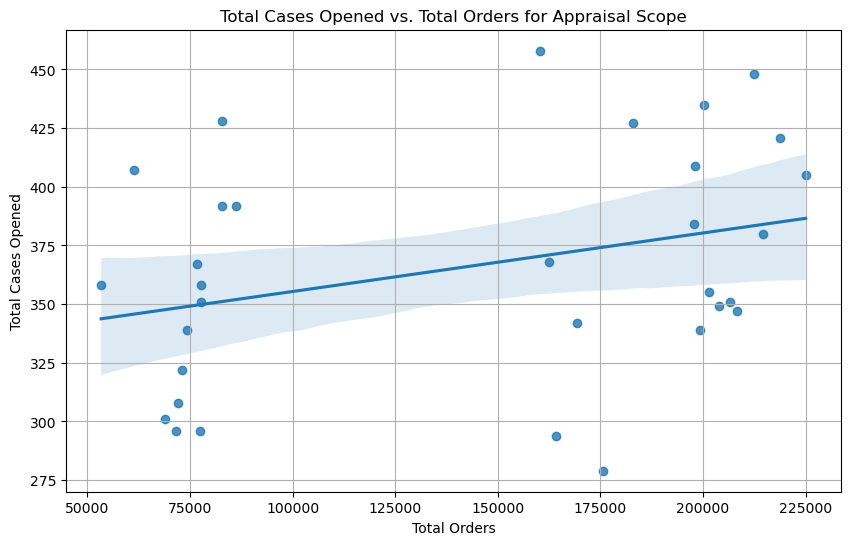

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
# Load the dataset from your local file
df = pd.read_csv(r'C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv')

# Filter for the 'Appraisal Scope' client
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()

# --- 2. Clean Data Types (The Fix) ---
# Convert the columns to a numeric data type.
# errors='coerce' will turn any non-numeric values into NaN (Not a Number).
appraisal_scope_df['TotalOrders'] = pd.to_numeric(appraisal_scope_df['TotalOrders'], errors='coerce')
appraisal_scope_df['total_cases_opened'] = pd.to_numeric(appraisal_scope_df['total_cases_opened'], errors='coerce')

# Drop rows where either of the columns has NaN values after conversion
appraisal_scope_df.dropna(subset=['TotalOrders', 'total_cases_opened'], inplace=True)

# --- 3. Create the Plot ---
# This plotting code will now work correctly with the cleaned data
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='TotalOrders', y='total_cases_opened')
plt.title('Total Cases Opened vs. Total Orders for Appraisal Scope')
plt.xlabel('Total Orders')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

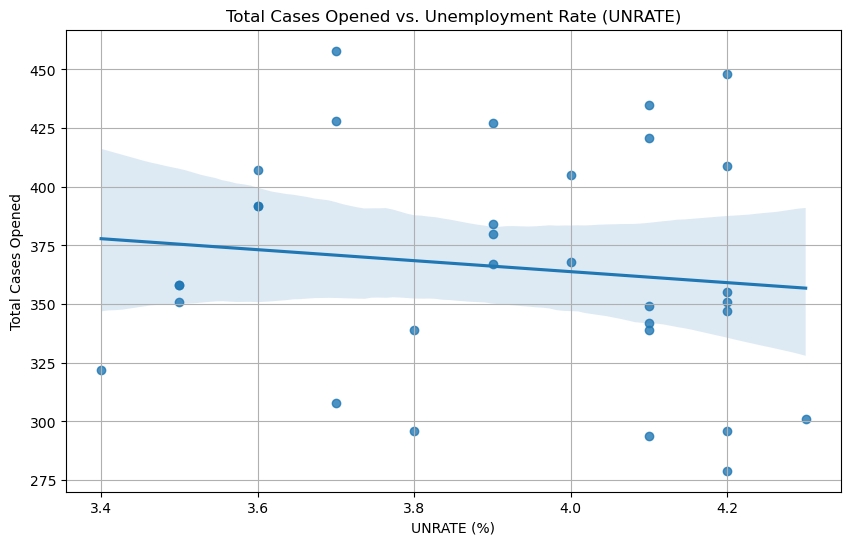

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='UNRATE', y='total_cases_opened')
plt.title('Total Cases Opened vs. Unemployment Rate (UNRATE)')
plt.xlabel('UNRATE (%)')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

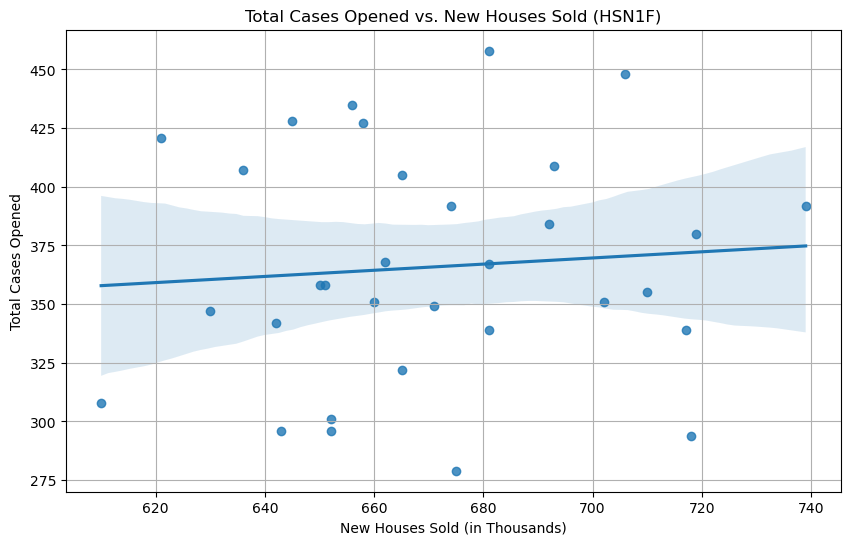

In [28]:

plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='HSN1F', y='total_cases_opened')
plt.title('Total Cases Opened vs. New Houses Sold (HSN1F)')
plt.xlabel('New Houses Sold (in Thousands)')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

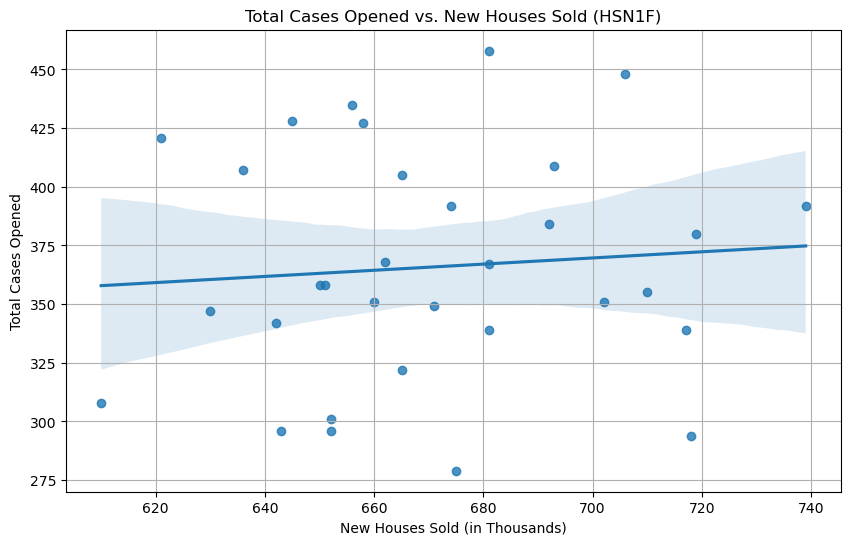

In [29]:
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='HSN1F', y='total_cases_opened')
plt.title('Total Cases Opened vs. New Houses Sold (HSN1F)')
plt.xlabel('New Houses Sold (in Thousands)')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

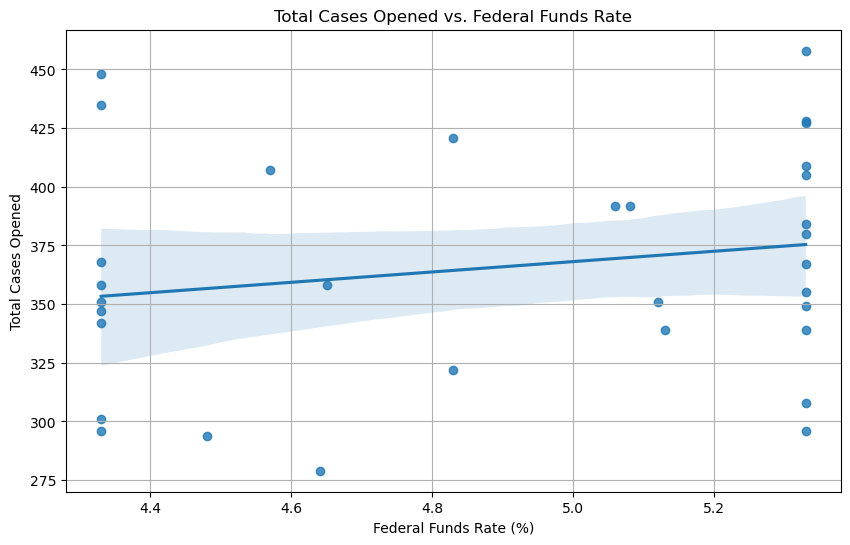

In [30]:
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='FEDFUNDS', y='total_cases_opened')
plt.title('Total Cases Opened vs. Federal Funds Rate')
plt.xlabel('Federal Funds Rate (%)')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

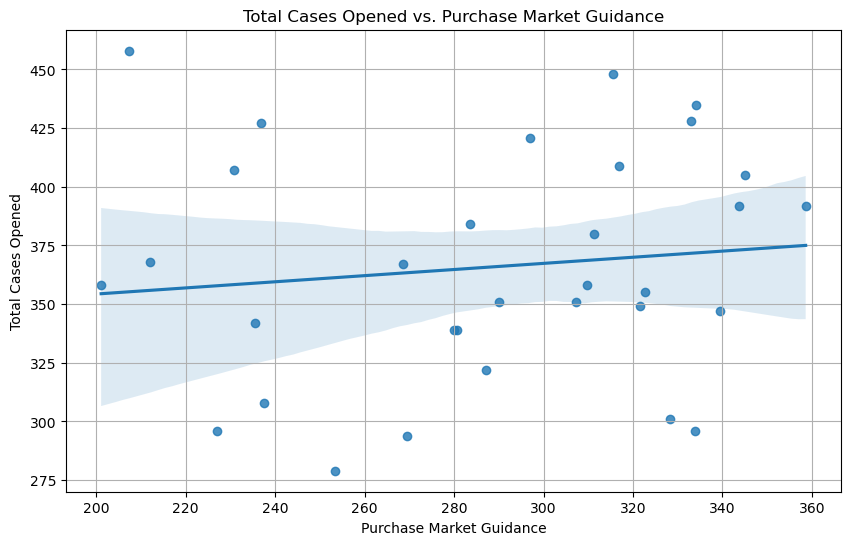

In [31]:
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='Purchase', y='total_cases_opened')
plt.title('Total Cases Opened vs. Purchase Market Guidance')
plt.xlabel('Purchase Market Guidance')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

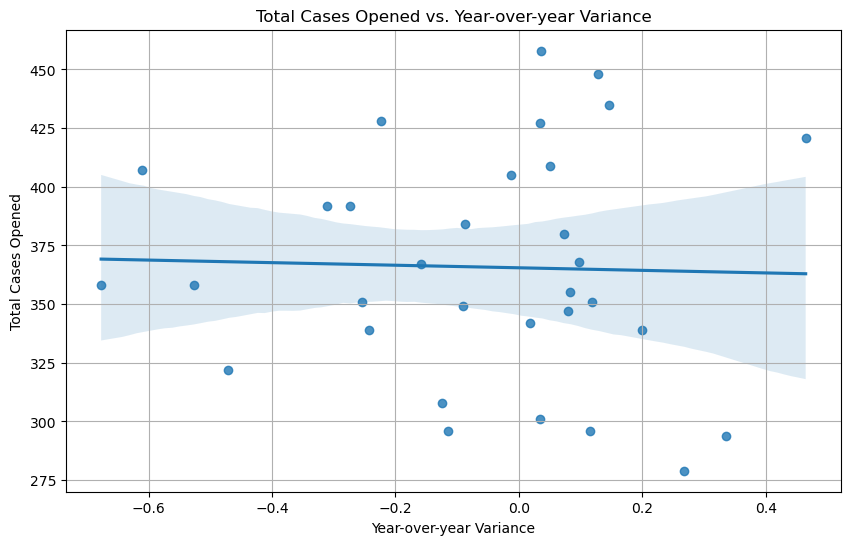

In [32]:
plt.figure(figsize=(10, 6))
sns.regplot(data=appraisal_scope_df, x='Year-over-year Variance', y='total_cases_opened')
plt.title('Total Cases Opened vs. Year-over-year Variance')
plt.xlabel('Year-over-year Variance')
plt.ylabel('Total Cases Opened')
plt.grid(True)
plt.show()

--- Correlation with 'total_cases_opened' ---
total_cases_opened         1.000000
business_day_count         0.388939
TotalOrders                0.323202
weekday_count              0.280295
FEDFUNDS                   0.198650
Purchase                   0.122477
HSN1F                      0.083983
Refinance                  0.050703
Year-over-year Variance   -0.029860
MORTGAGE30US              -0.084778
UNRATE                    -0.128110
holiday_count             -0.292312
Name: total_cases_opened, dtype: float64


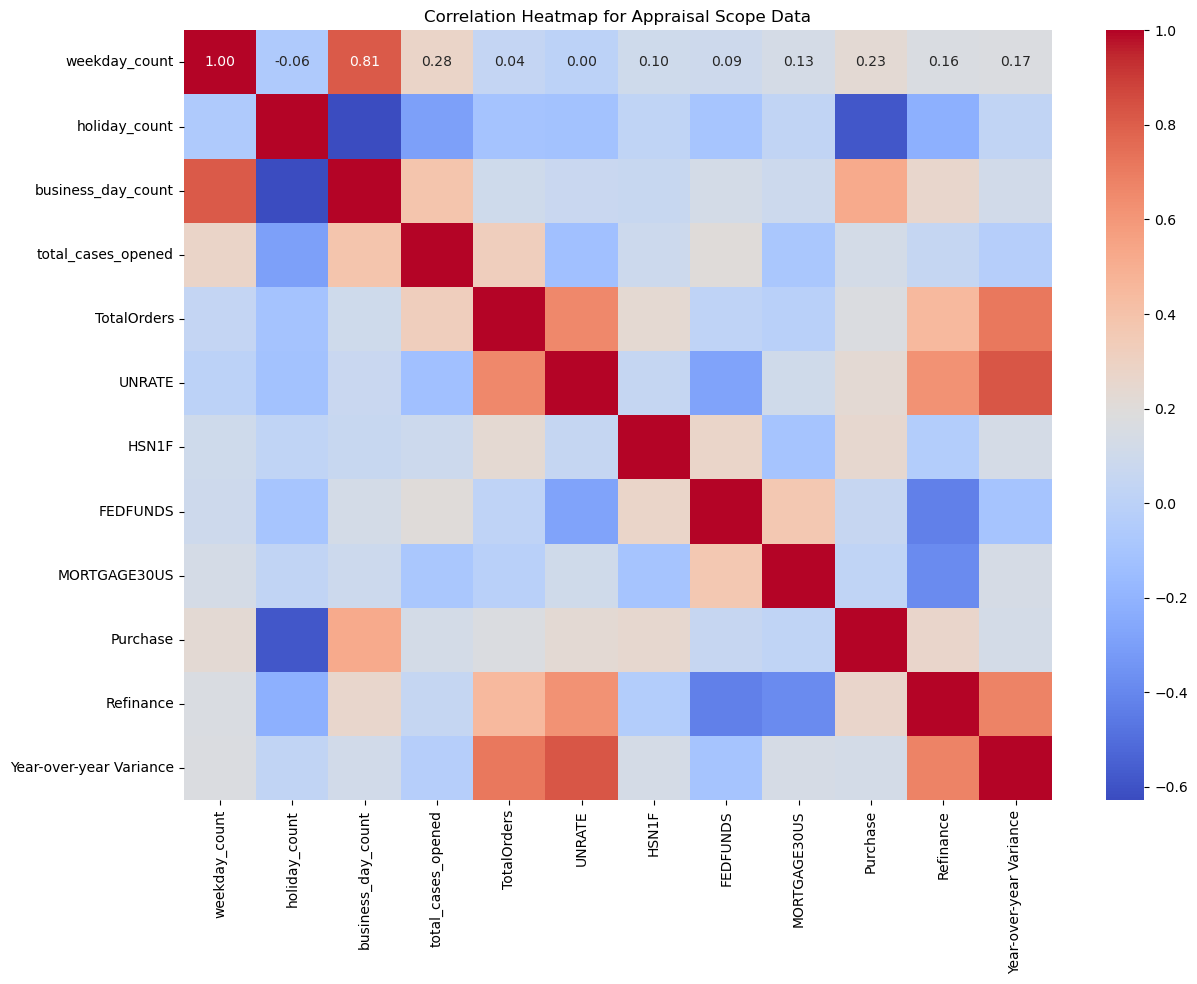

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This script assumes 'appraisal_scope_df' is your prepared DataFrame.

# --- 1. Select only numeric columns for the correlation matrix ---
numeric_df = appraisal_scope_df.select_dtypes(include=['float64', 'int64'])

# --- 2. Calculate and print the correlation with the target variable ---
# This gives you a direct, sorted list of the most important relationships.
target_correlations = numeric_df.corr()['total_cases_opened'].sort_values(ascending=False)
print("--- Correlation with 'total_cases_opened' ---")
print(target_correlations)

# --- 3. Generate the correlation heatmap (table) ---
# This provides a full view of how all variables relate to each other.
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Appraisal Scope Data')
plt.show()

In [34]:
import pandas as pd

# This script assumes 'appraisal_scope_df' is your prepared DataFrame.
# Select only numeric columns for the correlation matrix
numeric_df = appraisal_scope_df.select_dtypes(include=['float64', 'int64'])

# Calculate the Spearman correlation with the target variable
spearman_corr = numeric_df.corr(method='spearman')['total_cases_opened'].sort_values(ascending=False)

print("--- Spearman's Rank Correlation with 'total_cases_opened' ---")
print(spearman_corr)

--- Spearman's Rank Correlation with 'total_cases_opened' ---
total_cases_opened         1.000000
business_day_count         0.423805
TotalOrders                0.340515
weekday_count              0.330695
FEDFUNDS                   0.178658
Purchase                   0.166132
HSN1F                      0.070911
Refinance                  0.001650
MORTGAGE30US              -0.049509
Year-over-year Variance   -0.060145
UNRATE                    -0.177270
holiday_count             -0.304121
Name: total_cases_opened, dtype: float64


In [35]:
import pandas as pd

# This script assumes 'appraisal_scope_df' is your prepared DataFrame.
# Select only numeric columns for the correlation matrix
numeric_df = appraisal_scope_df.select_dtypes(include=['float64', 'int64'])

# Calculate the Kendall's Tau correlation with the target variable
kendall_corr = numeric_df.corr(method='kendall')['total_cases_opened'].sort_values(ascending=False)

print("--- Kendall's Tau Correlation with 'total_cases_opened' ---")
print(kendall_corr)

--- Kendall's Tau Correlation with 'total_cases_opened' ---
total_cases_opened         1.000000
business_day_count         0.321627
weekday_count              0.252365
TotalOrders                0.237085
FEDFUNDS                   0.124851
Purchase                   0.123608
HSN1F                      0.048880
Refinance                  0.010132
MORTGAGE30US              -0.030396
Year-over-year Variance   -0.058765
UNRATE                    -0.102920
holiday_count             -0.243092
Name: total_cases_opened, dtype: float64


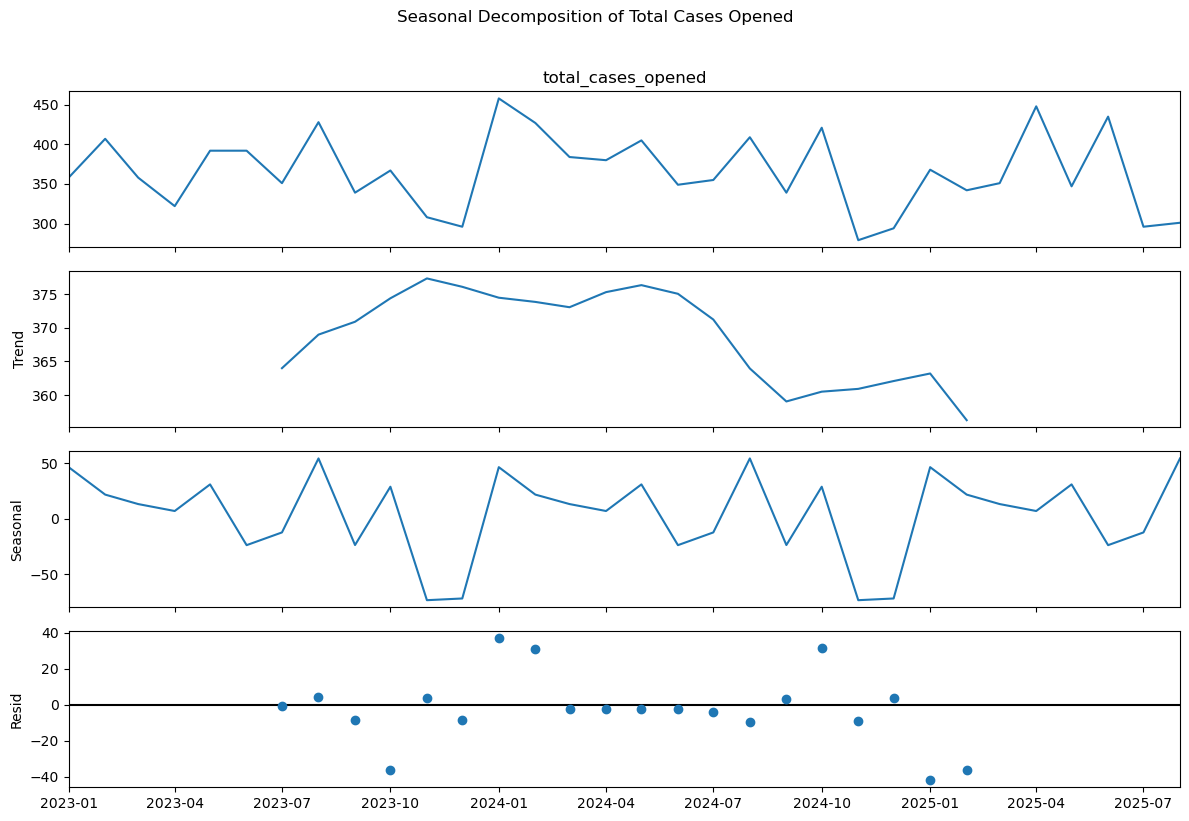

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 1. Prepare the Data ---
# This script assumes 'appraisal_scope_df' is your prepared DataFrame.
# The seasonal_decompose function requires a DatetimeIndex.
if not isinstance(appraisal_scope_df.index, pd.DatetimeIndex):
    appraisal_scope_df['date'] = pd.to_datetime(appraisal_scope_df['date'])
    appraisal_scope_df = appraisal_scope_df.set_index('date')


# --- 2. Perform and Plot the Decomposition ---
# We use a period of 12 because the data is monthly.
decomposition = seasonal_decompose(
    appraisal_scope_df['total_cases_opened'],
    model='additive',
    period=12
)

# The .plot() method automatically creates a figure with the four components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Total Cases Opened', y=1.02)
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# This script assumes 'appraisal_scope_df' is your prepared DataFrame.

# --- 1. Prepare the Data ---
# The adfuller function requires a series with no missing values.
target_series = appraisal_scope_df['total_cases_opened'].dropna()

# --- 2. Perform the ADF Test ---
result = adfuller(target_series)

# --- 3. Print and Interpret the Results ---
print('--- Augmented Dickey-Fuller Test Results ---')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

print("\n--- Conclusion ---")
if result[1] <= 0.05:
    print("The p-value is less than 0.05, so we reject the null hypothesis.")
    print("Result: The data is likely stationary.")
else:
    print("The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("Result: The data is likely non-stationary.")

--- Augmented Dickey-Fuller Test Results ---
ADF Statistic: -5.62423178763435
p-value: 1.126928663504391e-06
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647

--- Conclusion ---
The p-value is less than 0.05, so we reject the null hypothesis.
Result: The data is likely stationary.


In [38]:
import pandas as pd
import statsmodels.api as sm

# --- 1. Load and Prepare Data ---
df = pd.read_csv(r'C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()

# --- 2. Feature Engineering & Final Selection ---
appraisal_scope_df['month'] = appraisal_scope_df.index.month
features = ['TotalOrders', 'business_day_count'] # Using the final recommended features
target = 'total_cases_opened'
appraisal_scope_df = appraisal_scope_df.dropna(subset=[target] + features)

# --- 3. Split Data ---
X = appraisal_scope_df[features]
y = appraisal_scope_df[target]
split_point = len(appraisal_scope_df) - 6
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

# --- 4. Fit the OLS Model ---
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
residuals = model_sm.resid

print("OLS model has been fitted. Residuals are ready for testing.")

OLS model has been fitted. Residuals are ready for testing.


In [39]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test on the model's residuals
ljung_box_results = acorr_ljungbox(residuals, lags=[12], return_df=True)

print("--- Ljung-Box Test for Autocorrelation in Residuals ---")
print(ljung_box_results)

--- Ljung-Box Test for Autocorrelation in Residuals ---
      lb_stat  lb_pvalue
12  23.409069   0.024447


In [40]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test on the residuals
shapiro_test = shapiro(residuals)

print("\n--- Shapiro-Wilk Test for Normality of Residuals ---")
print(f"Test Statistic: {shapiro_test.statistic}")
print(f"P-value: {shapiro_test.pvalue}")


--- Shapiro-Wilk Test for Normality of Residuals ---
Test Statistic: 0.9524049162864685
P-value: 0.26382601261138916


In [41]:
from statsmodels.tsa.stattools import grangercausalitytests

# The test requires a DataFrame with the two time series
causality_df = appraisal_scope_df[['total_cases_opened', 'TotalOrders']].dropna()

# Perform the test. We'll test up to a lag of 3 months.
granger_results = grangercausalitytests(causality_df, maxlag=3, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1444  , p=0.7068  , df_denom=28, df_num=1
ssr based chi2 test:   chi2=0.1599  , p=0.6893  , df=1
likelihood ratio test: chi2=0.1595  , p=0.6896  , df=1
parameter F test:         F=0.1444  , p=0.7068  , df_denom=28, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7670  , p=0.0087  , df_denom=25, df_num=2
ssr based chi2 test:   chi2=13.8407 , p=0.0010  , df=2
likelihood ratio test: chi2=11.3810 , p=0.0034  , df=2
parameter F test:         F=5.7670  , p=0.0087  , df_denom=25, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4363  , p=0.0345  , df_denom=22, df_num=3
ssr based chi2 test:   chi2=13.5891 , p=0.0035  , df=3
likelihood ratio test: chi2=11.1448 , p=0.0110  , df=3
parameter F test:         F=3.4363  , p=0.0345  , df_denom=22, df_num=3


C:\Users\jhgonzalez\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jhgonzalez\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                  total_cases_opened   No. Observations:                   23
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -47.774
Date:                             Wed, 17 Sep 2025   AIC                            109.548
Time:                                     13:43:43   BIC                            111.666
Sample:                                 04-01-2023   HQIC                           107.224
                                      - 02-01-2025                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
business_day_count    14.3238      7.521      1.904      0.057      -0.418      29.065
Tot

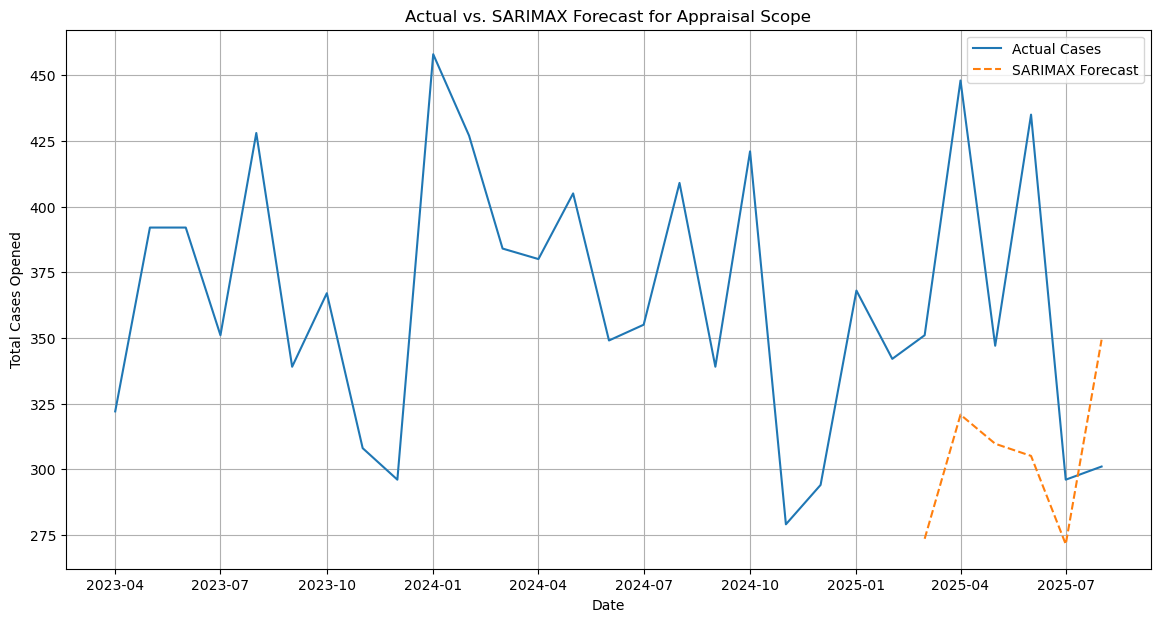

In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- Function to Calculate SMAPE ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- 1. Load and Prepare Data ---
df = pd.read_csv(r'C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()

# --- 2. Feature Engineering ---
# Create lagged features based on Granger Causality results
appraisal_scope_df['TotalOrders_lag_2'] = appraisal_scope_df['TotalOrders'].shift(2)
appraisal_scope_df['TotalOrders_lag_3'] = appraisal_scope_df['TotalOrders'].shift(3)

# Define features and target, and drop rows with missing values from lagging
features = ['business_day_count', 'TotalOrders_lag_2', 'TotalOrders_lag_3']
target = 'total_cases_opened'
appraisal_scope_df = appraisal_scope_df.dropna(subset=[target] + features)

# --- 3. Select Features and Split Data ---
X = appraisal_scope_df[features]
y = appraisal_scope_df[target]

# Split the data to test on the last 6 months
split_point = len(appraisal_scope_df) - 6
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# --- 4. Build and Train the SARIMAX Model ---
# The (p,d,q) and (P,D,Q,s) orders are hyperparameters.
# These are common starting points for monthly, seasonal data.
model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 0, 12))

results = model.fit(disp=False)
print(results.summary())


# --- 5. Make Predictions and Evaluate ---
predictions = results.get_forecast(steps=len(X_test), exog=X_test)
predicted_mean = predictions.predicted_mean

mae = mean_absolute_error(y_test, predicted_mean)
smape_error = smape(y_test, predicted_mean)

print("\n--- SARIMAX Model Evaluation (Last 6 Months) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_error:.2f}%")


# --- 6. Visualize the Results ---
plt.figure(figsize=(14, 7))
plt.plot(appraisal_scope_df.index, appraisal_scope_df[target], label='Actual Cases')
plt.plot(predicted_mean.index, predicted_mean.values, label='SARIMAX Forecast', linestyle='--')
plt.title('Actual vs. SARIMAX Forecast for Appraisal Scope')
plt.xlabel('Date')
plt.ylabel('Total Cases Opened')
plt.legend()
plt.grid(True)
plt.show()

--- OLS Model Evaluation (Last 6 Months) ---
Mean Absolute Error (MAE): 54.67
Symmetric Mean Absolute Percentage Error (SMAPE): 14.97%

--- OLS Regression Statistical Summary ---
                            OLS Regression Results                            
Dep. Variable:     total_cases_opened   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     8.992
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           0.000446
Time:                        13:45:27   Log-Likelihood:                -125.23
No. Observations:                  26   AIC:                             258.5
Df Residuals:                      22   BIC:                             263.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef  

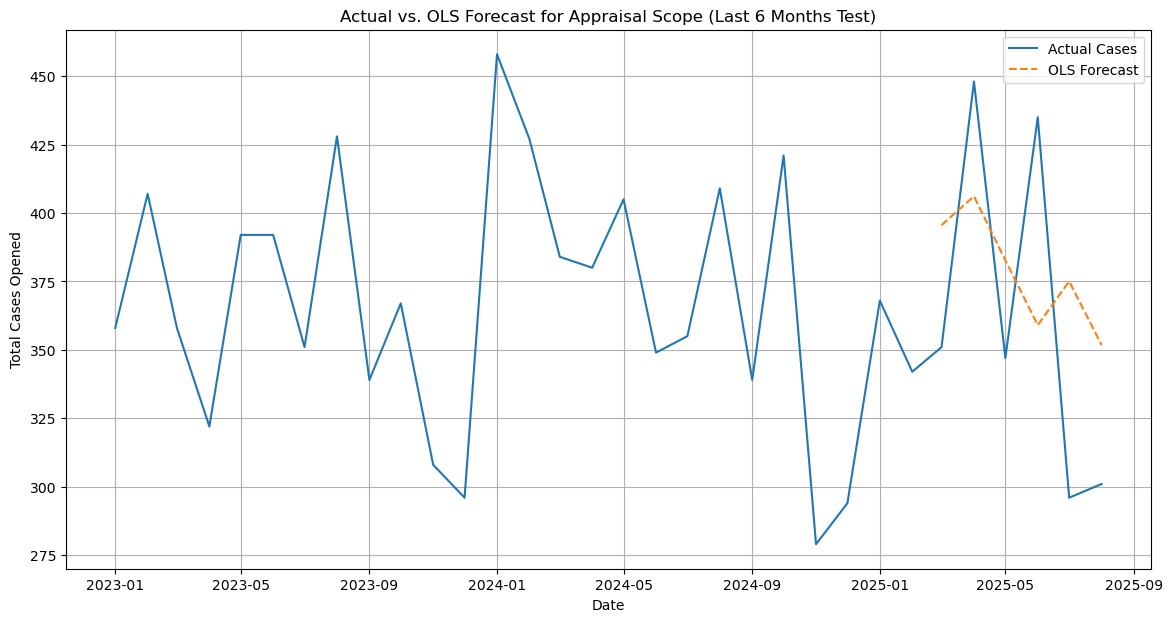

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Function to Calculate SMAPE ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- 1. Load and Prepare Data ---
df = pd.read_csv(r'C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()

# --- 2. Feature Engineering ---
appraisal_scope_df['month'] = appraisal_scope_df.index.month
features = ['TotalOrders', 'business_day_count', 'month']
target = 'total_cases_opened'
appraisal_scope_df = appraisal_scope_df.dropna(subset=[target] + features)

# --- 3. Select Features and Split Data ---
X = appraisal_scope_df[features]
y = appraisal_scope_df[target]

# Split the data to test on the last 6 months
split_point = len(appraisal_scope_df) - 6
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# --- 4. Build, Train, and Evaluate ---
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
smape_error = smape(y_test, predictions)

print("--- OLS Model Evaluation (Last 6 Months) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_error:.2f}%")

# --- 5. Generate Detailed Statistical Summary ---
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print("\n--- OLS Regression Statistical Summary ---")
print(model_sm.summary())

# --- 6. Visualize the Results ---
plt.figure(figsize=(14, 7))
plt.plot(appraisal_scope_df.index, appraisal_scope_df[target], label='Actual Cases')
plt.plot(X_test.index, predictions, label='OLS Forecast', linestyle='--')
plt.title('Actual vs. OLS Forecast for Appraisal Scope (Last 6 Months Test)')
plt.xlabel('Date')
plt.ylabel('Total Cases Opened')
plt.legend()
plt.grid(True)
plt.show()

--- Weighted Lag Average Model Evaluation (Last 6 Months) ---
Mean Absolute Error (MAE): 61.06
Symmetric Mean Absolute Percentage Error (SMAPE): 16.63%

--- OLS Regression Statistical Summary ---
                            OLS Regression Results                            
Dep. Variable:     total_cases_opened   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.254
Date:                Wed, 17 Sep 2025   Prob (F-statistic):              0.323
Time:                        13:52:05   Log-Likelihood:                -72.793
No. Observations:                  14   AIC:                             151.6
Df Residuals:                      11   BIC:                             153.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
              

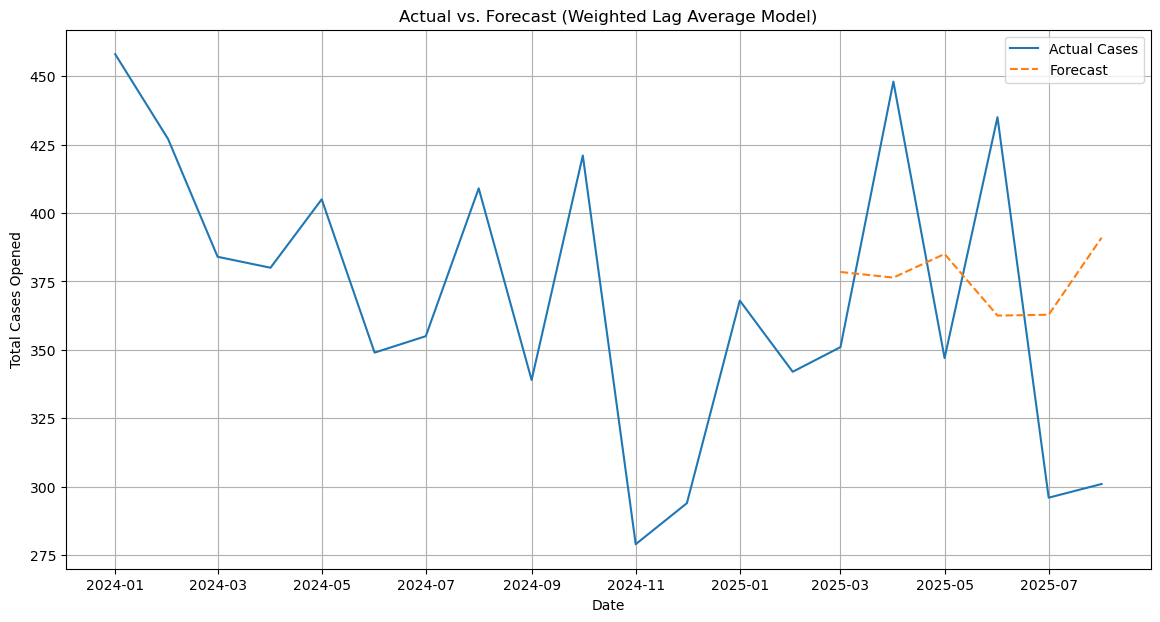

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Function to Calculate SMAPE ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- 1. Load and Prepare Data ---
df = pd.read_csv(r'C:\Users\jhgonzalez\Desktop\merged_forecasting_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
appraisal_scope_df = df[df['client'] == 'Appraisal Scope'].copy()
target = 'total_cases_opened'

# --- 2. Feature Engineering ---
# Use the [1, 12] lag combination for momentum and seasonality
df_lagged = appraisal_scope_df.copy()
df_lagged['lag_1'] = df_lagged[target].shift(1)
df_lagged['lag_12'] = df_lagged[target].shift(12)
df_lagged = df_lagged.dropna()

# --- 3. Select Features and Split Data ---
features = ['lag_1', 'lag_12']
X = df_lagged[features]
y = df_lagged[target]

# Split the data to test on the last 6 months
split_point = len(df_lagged) - 6
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# --- 4. Build, Train, and Evaluate ---
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
smape_error = smape(y_test, predictions)

print("--- Weighted Lag Average Model Evaluation (Last 6 Months) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_error:.2f}%")

# --- 5. Generate Detailed Statistical Summary ---
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print("\n--- OLS Regression Statistical Summary ---")
print(model_sm.summary())

# --- 6. Visualize the Results ---
plt.figure(figsize=(14, 7))
plt.plot(df_lagged.index, df_lagged[target], label='Actual Cases')
plt.plot(X_test.index, predictions, label='Forecast', linestyle='--')
plt.title('Actual vs. Forecast (Weighted Lag Average Model)')
plt.xlabel('Date')
plt.ylabel('Total Cases Opened')
plt.legend()
plt.grid(True)
plt.show()